In [2]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import requests
from api_keys import api_key
from scipy.stats import linregress

url = f"http://www.omdbapi.com/?apikey={api_key}&t="

In [3]:
# Read saved data
movie_data_df = pd.read_csv("../Resources/all_movie_data_clean_df.csv")

# Display sample data
movie_data_df.head(3)

,Unnamed: 0,Title,Released,Year,Rated,Runtime,Genre,Director,Writer,Actors,...,imdbID,BoxOffice,budget,keywords,Production,Awards,oscar_wins,oscar_nominations,award_wins,award_nominations
0,0,Jurassic World,2015-06-12,2015,PG-13,124,"['Action', ' Adventure', ' Sci-Fi']",['Colin Trevorrow'],"['Rick Jaffa', ' Amanda Silver', ' Colin Trevo...","['Chris Pratt', ' Bryce Dallas Howard', ' Ty S...",...,tt0369610,653406625,150000000,"['monster', 'dna', 'tyrannosaurus rex', 'veloc...","['Universal Studios', 'Amblin Entertainment', ...",15 wins & 58 nominations,0,0,15,58
1,1,Mad Max: Fury Road,2015-05-15,2015,R,120,"['Action', ' Adventure', ' Sci-Fi']",['George Miller'],"['George Miller', ' Brendan McCarthy', ' Nick ...","['Tom Hardy', ' Charlize Theron', ' Nicholas H...",...,tt1392190,154109060,150000000,"['future', 'chase', 'post-apocalyptic', 'dysto...","['Village Roadshow Pictures', 'Kennedy Miller ...",Won 6 Oscars. 247 wins & 234 nominations total,6,0,247,234
2,2,The Divergent Series: Insurgent,2015-03-20,2015,PG-13,119,"['Action', ' Adventure', ' Sci-Fi']",['Robert Schwentke'],"['Brian Duffield', ' Akiva Goldsman', ' Mark B...","['Shailene Woodley', ' Ansel Elgort', ' Theo J...",...,tt2908446,130179072,110000000,"['based on novel', 'revolution', 'dystopia', '...","['Summit Entertainment', 'Mandeville Films', '...",4 wins & 18 nominations,0,0,4,18


In [8]:
print(movie_data_df.shape)
print(movie_data_df.columns)

(1178, 27)
Index(['Unnamed: 0', 'Title', 'Released', 'Year', 'Rated', 'Runtime', 'Genre',
       'Director', 'Writer', 'Actors', 'Language', 'Country', 'Ratings',
       'Rotten Tomatoes', 'Metascore', 'imdbRating', 'imdbVotes', 'imdbID',
       'BoxOffice', 'budget', 'keywords', 'Production', 'Awards', 'oscar_wins',
       'oscar_nominations', 'award_wins', 'award_nominations'],
      dtype='object')


In [4]:
# Define a function to create Linear Regression plots
def regression_function(x_label, x_values, y_label, y_values, text_coordinates,):
    slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x_values, y_values, marker="o", facecolors="blue", edgecolors="black")
    plt.plot(x_values, regress_values,"r-")

    plt.annotate(line_eq, text_coordinates,fontsize=14,color="red")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    print(f"The r-value is: {rvalue}")

The r-value is: 0.626487178900805


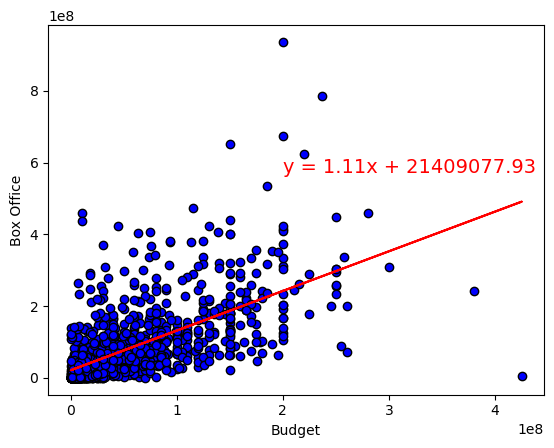

In [5]:
regression_function("Budget", movie_data_df["budget"], "Box Office", movie_data_df["BoxOffice"], (2e8, 5.7e8))

In [15]:
#Runtime Percentile
movie_data_df.Runtime.describe()

count    1178.000000
mean      111.061121
std        19.155616
min        63.000000
25%        97.000000
50%       108.000000
75%       122.000000
max       201.000000
Name: Runtime, dtype: float64

The r-value is: 0.3345147815051079


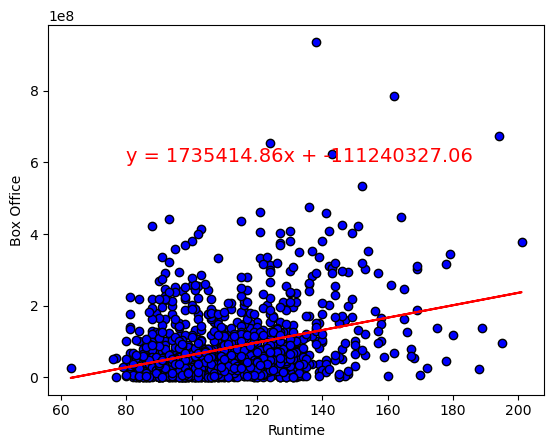

In [16]:
regression_function("Runtime", movie_data_df["Runtime"], "Box Office", movie_data_df["BoxOffice"], (80, 6e8))

In [9]:
#Generating Summary statistics for mean and median
summary_statistics = movie_data_df.groupby('Director').agg({'BoxOffice':['mean', 'median']})
summary_statistics

BoxOffice             
                                        mean       median
Director                                                 
["Gavin O'Connor"]              1.469892e+07   14698918.0
["Steve 'Spaz' Williams"]       3.738405e+07   37384046.0
['Adam McKay']                  1.125644e+08  119219978.0
['Adam Shankman']               7.795822e+07   77183980.0
['Agnieszka Wojtowicz-Vosloo']  1.085950e+05     108595.0
...                                      ...          ...
['Woody Allen']                 1.052572e+07   10525717.0
['Yorgos Lanthimos']            9.077245e+06    9077245.0
['Zack Snyder']                 1.305527e+08   59020957.0
['Zal Batmanglij']              2.301839e+06    2301839.0
['Émile Gaudreault']            6.253026e+06    6253026.0

[721 rows x 2 columns]

In [10]:
#Calculating the number of movies based on directors
movie_data_df.Director.value_counts()


['Steven Spielberg']                               11
['Steven Soderbergh']                              10
['John Carpenter']                                 10
['Clint Eastwood']                                  8
['Robert Zemeckis']                                 8
                                                   ..
['Christopher Morris']                              1
['Sngmoo Lee']                                      1
['Jim Mickle']                                      1
['Heidi Ewing', ' Alex Gibney', ' Seth Gordon']     1
['John Landis']                                     1
Name: Director, Length: 721, dtype: int64

In [13]:
#calculating top 10 directors based on revenue
High_Rev_directors = movie_data_df.groupby('Director').agg({'BoxOffice': 'mean', 'Title': 'count'})
TopDirectors = High_Rev_directors.sort_values('BoxOffice', ascending=False)[:10]
TopDirectors

,BoxOffice,Title
Director,,
['Colin Trevorrow'],6.534066e+08,1
['Joss Whedon'],5.411819e+08,2
['James Cameron'],4.992952e+08,3
"['Andrew Adamson', ' Kelly Asbury', ' Conrad Vernon']",4.412262e+08,1
"['Roger Allers', ' Rob Minkoff']",4.227838e+08,1
['Lee Unkrich'],4.150049e+08,1
['Shane Black'],4.090140e+08,1
"['Chris Buck', ' Jennifer Lee']",4.009530e+08,1
['J.J. Abrams'],3.992321e+08,3


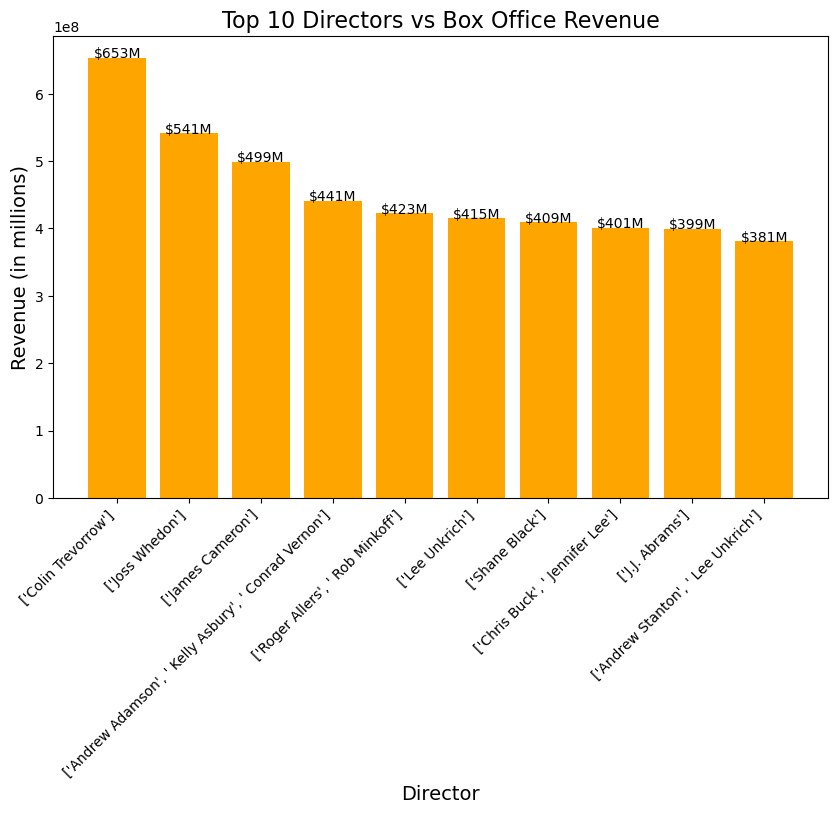

In [14]:
#Bar Chart on Director Vs Revenue
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(TopDirectors.index, TopDirectors['BoxOffice'], color='orange')

for Rev, val in enumerate(TopDirectors['BoxOffice']):
    ax.text(Rev, val, '${:,.0f}M'.format(val/1000000), ha='center')

# set the title and axis labels
ax.set_title('Top 10 Directors vs Box Office Revenue', fontsize=16)
ax.set_xlabel('Director', fontsize=14)
ax.set_ylabel('Revenue (in millions)', fontsize=14)

# rotate the x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# show the plot
plt.show()